# 🎯 AI IGNITE WEEK - TASK 1: Smart To-Do List Priority Predictor

## Problem Statement
Build an AI that learns from your completed tasks and predicts which new tasks you should do first based on your personal productivity patterns.

## Objectives
- Track when you complete different types of tasks
- Learn your productivity patterns (morning person? deadline-driven?)
- Automatically prioritize new tasks based on your habits
- Create a dataset of 250-500 tasks
- Build both rule-based and ML-based prediction systems

In [23]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
import warnings
import random
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 All libraries imported successfully!")
print("🎯 Ready to build the Smart To-Do List Priority Predictor!")

📚 All libraries imported successfully!
🎯 Ready to build the Smart To-Do List Priority Predictor!


## 📊 Step 1: Generate Comprehensive Sample Data (250-500 tasks)

We'll create a realistic dataset that includes:
- **Task types**: Email, Coding, Meeting, Personal, Research, Planning, Review, Admin
- **Time of day**: Morning, Afternoon, Evening
- **Deadline urgency**: High, Medium, Low
- **Task complexity**: Simple, Medium, Complex
- **Completion patterns**: Based on realistic productivity patterns

In [24]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

def generate_comprehensive_task_data(n_tasks=400):
    """
    Generate a comprehensive dataset of tasks with realistic patterns
    """
    
    # Define categories
    task_types = ['Email', 'Coding', 'Meeting', 'Personal', 'Research', 'Planning', 'Review', 'Admin']
    time_slots = ['Morning', 'Afternoon', 'Evening']
    urgency_levels = ['High', 'Medium', 'Low']
    complexity_levels = ['Simple', 'Medium', 'Complex']
    
    # Define realistic patterns for priority assignment
    priority_patterns = {
        # Task type influence on priority
        'task_priority_map': {
            'Email': {'High': 0.3, 'Medium': 0.5, 'Low': 0.2},
            'Coding': {'High': 0.4, 'Medium': 0.4, 'Low': 0.2},
            'Meeting': {'High': 0.5, 'Medium': 0.3, 'Low': 0.2},
            'Personal': {'High': 0.2, 'Medium': 0.3, 'Low': 0.5},
            'Research': {'High': 0.2, 'Medium': 0.5, 'Low': 0.3},
            'Planning': {'High': 0.3, 'Medium': 0.4, 'Low': 0.3},
            'Review': {'High': 0.4, 'Medium': 0.4, 'Low': 0.2},
            'Admin': {'High': 0.3, 'Medium': 0.4, 'Low': 0.3}
        },
        
        # Time-based patterns (morning person profile)
        'time_priority_boost': {
            'Morning': 1.2,  # 20% boost for morning tasks
            'Afternoon': 1.0,  # Normal priority
            'Evening': 0.8   # 20% reduction for evening tasks
        },
        
        # Urgency directly affects priority
        'urgency_multiplier': {
            'High': 1.5,
            'Medium': 1.0,
            'Low': 0.7
        },
        
        # Complexity affects priority (complex tasks often postponed)
        'complexity_modifier': {
            'Simple': 1.1,
            'Medium': 1.0,
            'Complex': 0.9
        }
    }
    
    tasks = []
    
    for i in range(n_tasks):
        # Generate basic task properties
        task_type = np.random.choice(task_types)
        time_slot = np.random.choice(time_slots, p=[0.4, 0.4, 0.2])  # Morning bias
        urgency = np.random.choice(urgency_levels, p=[0.3, 0.5, 0.2])  # Medium urgency most common
        complexity = np.random.choice(complexity_levels, p=[0.3, 0.5, 0.2])  # Medium complexity most common
        
        # Calculate priority score based on patterns
        base_scores = priority_patterns['task_priority_map'][task_type]
        time_boost = priority_patterns['time_priority_boost'][time_slot]
        urgency_mult = priority_patterns['urgency_multiplier'][urgency]
        complexity_mod = priority_patterns['complexity_modifier'][complexity]
        
        # Calculate weighted probability for each priority level
        priority_score = {}
        for priority_level in ['High', 'Medium', 'Low']:
            score = base_scores[priority_level] * time_boost * urgency_mult * complexity_mod
            # Add some randomness
            score *= np.random.uniform(0.8, 1.2)
            priority_score[priority_level] = score
        
        # Normalize scores to probabilities
        total_score = sum(priority_score.values())
        priority_probs = [priority_score[p]/total_score for p in ['High', 'Medium', 'Low']]
        
        # Select priority based on calculated probabilities
        priority = np.random.choice(['High', 'Medium', 'Low'], p=priority_probs)
        
        # Generate some additional realistic features
        estimated_duration = np.random.choice([15, 30, 45, 60, 90, 120], 
                                            p=[0.2, 0.3, 0.2, 0.15, 0.1, 0.05])
        
        # Add day of week (workdays vs weekends)
        day_of_week = np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                     p=[0.18, 0.18, 0.18, 0.18, 0.18, 0.05, 0.05])
        
        task = {
            'task_id': f'TASK_{i+1:03d}',
            'task_type': task_type,
            'time_of_day': time_slot,
            'urgency': urgency,
            'complexity': complexity,
            'priority': priority,
            'estimated_duration': estimated_duration,
            'day_of_week': day_of_week
        }
        
        tasks.append(task)
    
    return pd.DataFrame(tasks)

# Generate the dataset
print("🔄 Generating comprehensive task dataset...")
data = generate_comprehensive_task_data(400)

print(f"✅ Generated {len(data)} tasks successfully!")
print(f"📈 Dataset shape: {data.shape}")
print("\n📋 First 5 tasks:")
print(data.head())

print("\n📊 Dataset overview:")
print(f"Task types: {data['task_type'].nunique()} unique types")
print(f"Time slots: {data['time_of_day'].nunique()} slots")
print(f"Priority distribution:")
print(data['priority'].value_counts())

🔄 Generating comprehensive task dataset...
✅ Generated 400 tasks successfully!
📈 Dataset shape: (400, 8)

📋 First 5 tasks:
    task_id task_type time_of_day urgency complexity priority  \
0  TASK_001    Review   Afternoon    High     Medium   Medium   
1  TASK_002   Meeting     Morning     Low    Complex     High   
2  TASK_003     Email   Afternoon  Medium     Simple   Medium   
3  TASK_004     Email     Morning  Medium     Simple      Low   
4  TASK_005  Personal     Morning  Medium     Medium     High   

   estimated_duration day_of_week  
0                  30      Monday  
1                  45   Wednesday  
2                  30      Sunday  
3                  30      Monday  
4                  60   Wednesday  

📊 Dataset overview:
Task types: 8 unique types
Time slots: 3 slots
Priority distribution:
priority
Medium    153
High      144
Low       103
Name: count, dtype: int64


🔍 DETAILED DATA ANALYSIS


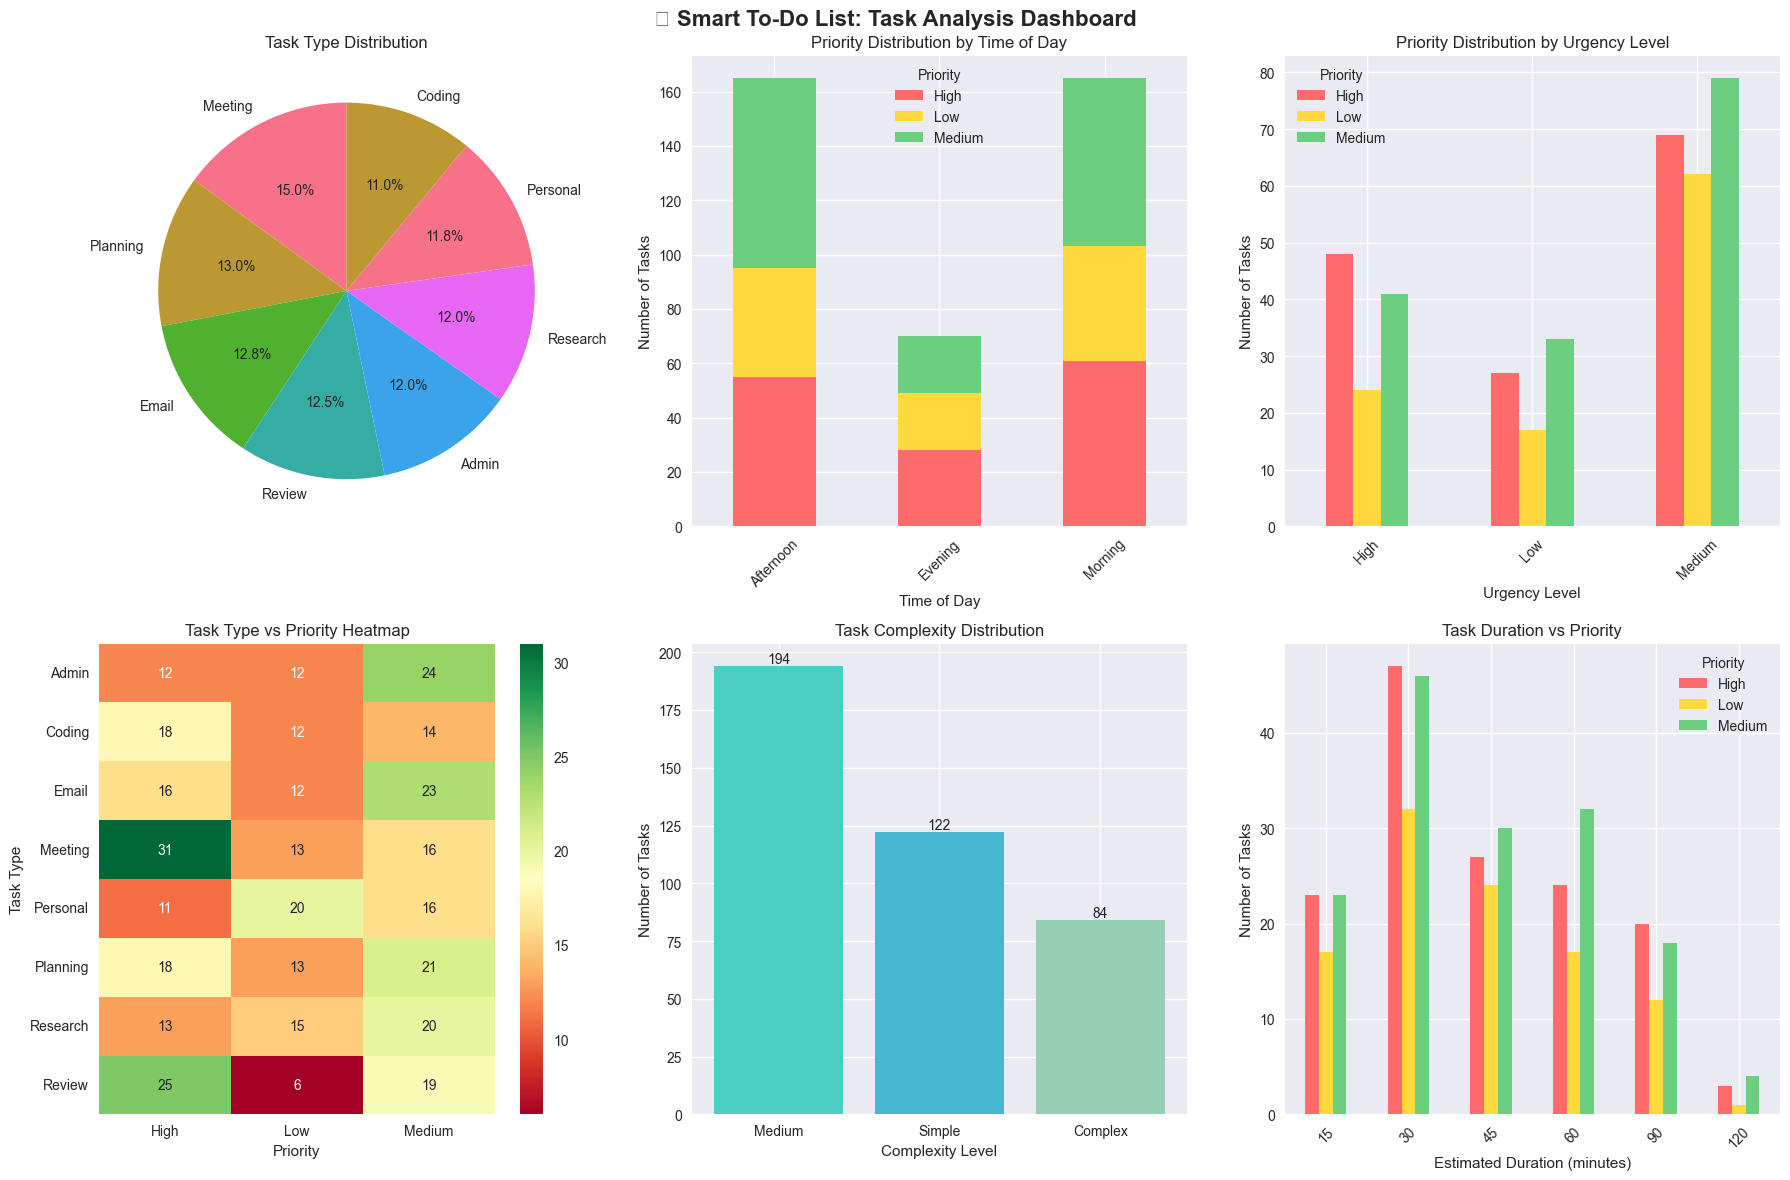


📈 DETAILED STATISTICS
------------------------------
📋 Total Tasks: 400
🎯 Task Types: Review, Meeting, Email, Personal, Planning, Research, Coding, Admin
⏰ Time Slots: Afternoon, Morning, Evening
🚨 Urgency Levels: High, Low, Medium

🔄 Priority Distribution:
   Medium: 153 tasks (38.2%)
   High: 144 tasks (36.0%)
   Low: 103 tasks (25.8%)

📊 Task Type Breakdown:
   Meeting: 60 tasks (15.0%)
   Planning: 52 tasks (13.0%)
   Email: 51 tasks (12.8%)
   Review: 50 tasks (12.5%)
   Admin: 48 tasks (12.0%)
   Research: 48 tasks (12.0%)
   Personal: 47 tasks (11.8%)
   Coding: 44 tasks (11.0%)


In [25]:
# Detailed data exploration and visualization
print("🔍 DETAILED DATA ANALYSIS")
print("=" * 50)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📊 Smart To-Do List: Task Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Task Type Distribution
task_counts = data['task_type'].value_counts()
axes[0, 0].pie(task_counts.values, labels=task_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Task Type Distribution')

# 2. Priority by Time of Day
time_priority = pd.crosstab(data['time_of_day'], data['priority'])
time_priority.plot(kind='bar', ax=axes[0, 1], stacked=True, color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
axes[0, 1].set_title('Priority Distribution by Time of Day')
axes[0, 1].set_xlabel('Time of Day')
axes[0, 1].set_ylabel('Number of Tasks')
axes[0, 1].legend(title='Priority')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Urgency vs Priority
urgency_priority = pd.crosstab(data['urgency'], data['priority'])
urgency_priority.plot(kind='bar', ax=axes[0, 2], color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
axes[0, 2].set_title('Priority Distribution by Urgency Level')
axes[0, 2].set_xlabel('Urgency Level')
axes[0, 2].set_ylabel('Number of Tasks')
axes[0, 2].legend(title='Priority')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Task Type vs Priority Heatmap
type_priority = pd.crosstab(data['task_type'], data['priority'])
sns.heatmap(type_priority, annot=True, fmt='d', cmap='RdYlGn', ax=axes[1, 0])
axes[1, 0].set_title('Task Type vs Priority Heatmap')
axes[1, 0].set_xlabel('Priority')
axes[1, 0].set_ylabel('Task Type')

# 5. Complexity Distribution
complexity_counts = data['complexity'].value_counts()
bars = axes[1, 1].bar(complexity_counts.index, complexity_counts.values, 
                     color=['#4ecdc4', '#45b7d1', '#96ceb4'])
axes[1, 1].set_title('Task Complexity Distribution')
axes[1, 1].set_xlabel('Complexity Level')
axes[1, 1].set_ylabel('Number of Tasks')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom')

# 6. Duration vs Priority
duration_priority = data.groupby(['estimated_duration', 'priority']).size().unstack(fill_value=0)
duration_priority.plot(kind='bar', ax=axes[1, 2], color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
axes[1, 2].set_title('Task Duration vs Priority')
axes[1, 2].set_xlabel('Estimated Duration (minutes)')
axes[1, 2].set_ylabel('Number of Tasks')
axes[1, 2].legend(title='Priority')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n📈 DETAILED STATISTICS")
print("-" * 30)

print(f"📋 Total Tasks: {len(data)}")
print(f"🎯 Task Types: {', '.join(data['task_type'].unique())}")
print(f"⏰ Time Slots: {', '.join(data['time_of_day'].unique())}")
print(f"🚨 Urgency Levels: {', '.join(data['urgency'].unique())}")

print("\n🔄 Priority Distribution:")
priority_dist = data['priority'].value_counts()
for priority, count in priority_dist.items():
    percentage = (count / len(data)) * 100
    print(f"   {priority}: {count} tasks ({percentage:.1f}%)")

print("\n📊 Task Type Breakdown:")
type_dist = data['task_type'].value_counts()
for task_type, count in type_dist.items():
    percentage = (count / len(data)) * 100
    print(f"   {task_type}: {count} tasks ({percentage:.1f}%)")

## 🎯 Step 2: Build Simple Rule-Based Priority System

Before diving into machine learning, let's create intuitive rules based on common productivity patterns:

### Rules:
1. **High Urgency + Morning** → HIGH Priority  
2. **Meetings** → HIGH Priority (time-sensitive)
3. **High Urgency** → HIGH Priority
4. **Morning + (Email/Admin)** → HIGH Priority  
5. **Complex + Evening** → LOW Priority (avoid difficult tasks late)
6. **Personal + Evening** → MEDIUM Priority
7. **Default** → Based on urgency level

In [26]:
def rule_based_priority_predictor(task_type, time_of_day, urgency, complexity):
    """
    Rule-based priority prediction system based on productivity patterns
    """
    
    # Rule 1: High urgency + Morning = High Priority
    if urgency == 'High' and time_of_day == 'Morning':
        return 'High', "High urgency task in morning (peak productivity time)"
    
    # Rule 2: Meetings are always high priority (time-sensitive)
    if task_type == 'Meeting':
        return 'High', "Meetings are time-sensitive and involve others"
    
    # Rule 3: All high urgency tasks get high priority
    if urgency == 'High':
        return 'High', "High urgency task requires immediate attention"
    
    # Rule 4: Email/Admin in morning = High priority (clear inbox early)
    if task_type in ['Email', 'Admin'] and time_of_day == 'Morning':
        return 'High', "Clear communications and admin tasks early in the day"
    
    # Rule 5: Complex tasks in evening = Low priority (avoid mental fatigue)
    if complexity == 'Complex' and time_of_day == 'Evening':
        return 'Low', "Avoid complex tasks when energy is low"
    
    # Rule 6: Personal tasks in evening = Medium priority (work-life balance)
    if task_type == 'Personal' and time_of_day == 'Evening':
        return 'Medium', "Personal tasks fit well in evening hours"
    
    # Rule 7: Coding in morning = High priority (complex work needs focus)
    if task_type == 'Coding' and time_of_day == 'Morning':
        return 'High', "Coding requires focus, best done in morning"
    
    # Rule 8: Research tasks = Medium priority (unless urgent)
    if task_type == 'Research' and urgency != 'High':
        return 'Medium', "Research tasks can be scheduled flexibly"
    
    # Default rules based on urgency
    if urgency == 'Medium':
        return 'Medium', f"Medium urgency {task_type.lower()} task"
    else:  # Low urgency
        return 'Low', f"Low urgency {task_type.lower()} task"

# Test the rule-based system on our dataset
print("🎯 TESTING RULE-BASED PRIORITY SYSTEM")
print("=" * 50)

rule_predictions = []
rule_reasons = []

for _, task in data.iterrows():
    predicted_priority, reason = rule_based_priority_predictor(
        task['task_type'], 
        task['time_of_day'], 
        task['urgency'], 
        task['complexity']
    )
    rule_predictions.append(predicted_priority)
    rule_reasons.append(reason)

# Add predictions to dataframe for analysis
data['rule_predicted_priority'] = rule_predictions
data['rule_reason'] = rule_reasons

# Calculate accuracy
rule_accuracy = accuracy_score(data['priority'], data['rule_predicted_priority'])

print(f"📊 Rule-based System Accuracy: {rule_accuracy:.3f} ({rule_accuracy*100:.1f}%)")

# Detailed analysis
from sklearn.metrics import classification_report
rule_report = classification_report(data['priority'], data['rule_predicted_priority'], 
                                  target_names=['High', 'Low', 'Medium'], output_dict=True)

print("\n📋 DETAILED PERFORMANCE REPORT:")
print("-" * 35)
for priority in ['High', 'Medium', 'Low']:
    if priority in rule_report:
        precision = rule_report[priority]['precision']
        recall = rule_report[priority]['recall']
        f1 = rule_report[priority]['f1-score']
        support = rule_report[priority]['support']
        
        print(f"{priority} Priority:")
        print(f"   Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | Support: {int(support)}")

# Confusion Matrix
rule_cm = pd.crosstab(data['priority'], data['rule_predicted_priority'], 
                     rownames=['Actual'], colnames=['Predicted'])

print(f"\n🔄 Confusion Matrix:")
print(rule_cm)

# Show some example predictions
print(f"\n🔍 EXAMPLE RULE-BASED PREDICTIONS:")
print("-" * 45)
sample_data = data.sample(10, random_state=42)
for _, task in sample_data.iterrows():
    actual = task['priority']
    predicted = task['rule_predicted_priority']
    emoji = "✅" if actual == predicted else "❌"
    
    print(f"{emoji} {task['task_type']} | {task['time_of_day']} | {task['urgency']} urgency")
    print(f"   Actual: {actual} | Predicted: {predicted}")
    print(f"   Reason: {task['rule_reason']}")
    print()

🎯 TESTING RULE-BASED PRIORITY SYSTEM
📊 Rule-based System Accuracy: 0.375 (37.5%)

📋 DETAILED PERFORMANCE REPORT:
-----------------------------------
High Priority:
   Precision: 0.400 | Recall: 0.542 | F1: 0.460 | Support: 144
Medium Priority:
   Precision: 0.380 | Recall: 0.373 | F1: 0.376 | Support: 153
Low Priority:
   Precision: 0.273 | Recall: 0.146 | F1: 0.190 | Support: 103

🔄 Confusion Matrix:
Predicted  High  Low  Medium
Actual                      
High         78   17      49
Low          44   15      44
Medium       73   23      57

🔍 EXAMPLE RULE-BASED PREDICTIONS:
---------------------------------------------
✅ Planning | Afternoon | Medium urgency
   Actual: Medium | Predicted: Medium
   Reason: Medium urgency planning task

❌ Meeting | Afternoon | Medium urgency
   Actual: Low | Predicted: High
   Reason: Meetings are time-sensitive and involve others

✅ Planning | Evening | Medium urgency
   Actual: Medium | Predicted: Medium
   Reason: Medium urgency planning task

✅ 

## 🤖 Step 3: Machine Learning Models

Now let's build ML models to learn patterns automatically from the data. We'll compare:
1. **Decision Tree** (easy to interpret)
2. **Random Forest** (ensemble method)
3. **Gradient Boosting** (advanced ensemble)
4. **Support Vector Machine** (pattern recognition)

In [27]:
# Prepare data for machine learning
print("🔧 PREPARING DATA FOR MACHINE LEARNING")
print("=" * 50)

# Select features for ML models
feature_columns = ['task_type', 'time_of_day', 'urgency', 'complexity', 'estimated_duration', 'day_of_week']
target_column = 'priority'

# Create feature matrix
X = data[feature_columns].copy()
y = data[target_column].copy()

# Encode categorical variables
label_encoders = {}
for column in ['task_type', 'time_of_day', 'urgency', 'complexity', 'day_of_week']:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"✅ Features prepared: {feature_columns}")
print(f"📊 Feature matrix shape: {X.shape}")
print(f"🎯 Target classes: {le_target.classes_}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"📈 Training set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")

# Display the encoded feature sample
print(f"\n🔍 Sample of encoded features:")
print(X.head())

print(f"\n📋 Label encoding mappings:")
for col, encoder in label_encoders.items():
    mapping = {i: label for i, label in enumerate(encoder.classes_)}
    print(f"   {col}: {mapping}")

🔧 PREPARING DATA FOR MACHINE LEARNING
✅ Features prepared: ['task_type', 'time_of_day', 'urgency', 'complexity', 'estimated_duration', 'day_of_week']
📊 Feature matrix shape: (400, 6)
🎯 Target classes: [np.str_('High') np.str_('Low') np.str_('Medium')]
📈 Training set: 320 samples
📊 Test set: 80 samples

🔍 Sample of encoded features:
   task_type  time_of_day  urgency  complexity  estimated_duration  \
0          7            0        0           1                  30   
1          3            2        1           0                  45   
2          2            0        2           2                  30   
3          2            2        2           2                  30   
4          4            2        2           1                  60   

   day_of_week  
0            1  
1            6  
2            3  
3            1  
4            6  

📋 Label encoding mappings:
   task_type: {0: np.str_('Admin'), 1: np.str_('Coding'), 2: np.str_('Email'), 3: np.str_('Meeting'), 4: np.str_('P

In [28]:
# Train and evaluate multiple ML models
print("🤖 TRAINING MACHINE LEARNING MODELS")
print("=" * 50)

# Define models to compare
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'CV Mean': cv_mean,
        'CV Std': cv_std
    })
    
    print(f"   Train Accuracy: {train_accuracy:.3f}")
    print(f"   Test Accuracy: {test_accuracy:.3f}")
    print(f"   CV Score: {cv_mean:.3f} (±{cv_std:.3f})")

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print(f"\n📊 MODEL COMPARISON RESULTS:")
print("=" * 60)
print(results_df.round(3).to_string(index=False))

# Find the best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.3f}")

# Detailed evaluation of the best model
y_pred_best = best_model.predict(X_test)

print(f"\n📋 DETAILED EVALUATION - {best_model_name}:")
print("-" * 50)

# Classification report
report = classification_report(y_test, y_pred_best, 
                             target_names=le_target.classes_, 
                             output_dict=True)

for class_name in le_target.classes_:
    if class_name in report:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        print(f"{class_name} Priority:")
        print(f"   Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | Support: {int(support)}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(cm, 
                     index=le_target.classes_, 
                     columns=le_target.classes_)

print(f"\n🔄 Confusion Matrix:")
print(cm_df)

🤖 TRAINING MACHINE LEARNING MODELS

🔄 Training Decision Tree...
   Train Accuracy: 0.909
   Test Accuracy: 0.350
   CV Score: 0.362 (±0.052)

🔄 Training Random Forest...
   Train Accuracy: 0.994
   Test Accuracy: 0.338
   CV Score: 0.394 (±0.044)

🔄 Training Gradient Boosting...
   Train Accuracy: 0.744
   Test Accuracy: 0.463
   CV Score: 0.400 (±0.044)

🔄 Training SVM...
   Train Accuracy: 0.384
   Test Accuracy: 0.375
   CV Score: 0.381 (±0.008)

📊 MODEL COMPARISON RESULTS:
            Model  Train Accuracy  Test Accuracy  CV Mean  CV Std
Gradient Boosting           0.744          0.462    0.400   0.044
              SVM           0.384          0.375    0.381   0.008
    Decision Tree           0.909          0.350    0.362   0.052
    Random Forest           0.994          0.338    0.394   0.044

🏆 BEST MODEL: Gradient Boosting
   Test Accuracy: 0.463

📋 DETAILED EVALUATION - Gradient Boosting:
--------------------------------------------------
High Priority:
   Precision: 0.459 |

## 🎯 Step 4: Smart To-Do Predictor Class

Now let's create a comprehensive predictor that combines our best ML model with rule-based reasoning to provide both predictions and explanations.

In [30]:
class SmartTodoPredictor:
    """
    Advanced Smart To-Do List Priority Predictor
    Combines ML predictions with rule-based explanations
    """
    
    def __init__(self, model, label_encoders, target_encoder):
        self.model = model
        self.label_encoders = label_encoders
        self.target_encoder = target_encoder
        
        # Productivity insights based on learned patterns
        self.insights = {
            'morning_boost': ['Email', 'Admin', 'Coding'],
            'meeting_priority': True,
            'complex_evening_avoid': True,
            'personal_evening_fit': True
        }
    
    def encode_task(self, task_type, time_of_day, urgency, complexity, estimated_duration, day_of_week):
        """Encode a new task for prediction"""
        try:
            encoded_task = []
            
            # Encode each feature
            features = [task_type, time_of_day, urgency, complexity, day_of_week]
            feature_names = ['task_type', 'time_of_day', 'urgency', 'complexity', 'day_of_week']
            
            for feature, name in zip(features, feature_names):
                if feature in self.label_encoders[name].classes_:
                    encoded_value = self.label_encoders[name].transform([feature])[0]
                else:
                    # Handle unknown categories (use most common)
                    encoded_value = 0
                encoded_task.append(encoded_value)
            
            # Add estimated duration (already numeric)
            encoded_task.append(estimated_duration)
            
            return np.array(encoded_task).reshape(1, -1)
        
        except Exception as e:
            print(f"Encoding error: {e}")
            return None
    
    def predict_priority(self, task_type, time_of_day, urgency, complexity, 
                        estimated_duration=60, day_of_week='Monday'):
        """
        Predict task priority with confidence and reasoning
        """
        
        # Encode the task
        X_encoded = self.encode_task(task_type, time_of_day, urgency, complexity, 
                                   estimated_duration, day_of_week)
        
        if X_encoded is None:
            return None
        
        # Get ML prediction and probabilities
        prediction = self.model.predict(X_encoded)[0]
        probabilities = self.model.predict_proba(X_encoded)[0]
        
        # Convert prediction back to text
        predicted_priority = self.target_encoder.classes_[prediction]
        
        # Get confidence (probability of predicted class)
        confidence = probabilities[prediction]
        
        # Generate explanation
        explanation = self._generate_explanation(
            task_type, time_of_day, urgency, complexity, 
            predicted_priority, confidence
        )
        
        return {
            'task': f"{task_type} task",
            'predicted_priority': predicted_priority,
            'confidence': confidence,
            'explanation': explanation,
            'all_probabilities': {
                self.target_encoder.classes_[i]: prob 
                for i, prob in enumerate(probabilities)
            }
        }
    
    def _generate_explanation(self, task_type, time_of_day, urgency, complexity, 
                            predicted_priority, confidence):
        """Generate human-readable explanation for the prediction"""
        
        explanations = []
        
        # Confidence level
        if confidence > 0.7:
            conf_text = "high confidence"
        elif confidence > 0.5:
            conf_text = "moderate confidence"
        else:
            conf_text = "low confidence"
        
        explanations.append(f"Predicted with {conf_text} ({confidence:.1%})")
        
        # Time-based insights
        if time_of_day == 'Morning' and task_type in self.insights['morning_boost']:
            explanations.append(f"{task_type} tasks are most effective in the morning")
        
        if time_of_day == 'Evening' and complexity == 'Complex':
            explanations.append("Complex tasks should be avoided in the evening")
        
        if time_of_day == 'Evening' and task_type == 'Personal':
            explanations.append("Personal tasks fit well in evening hours")
        
        # Urgency-based insights
        if urgency == 'High':
            explanations.append("High urgency requires immediate attention")
        elif urgency == 'Low' and predicted_priority == 'High':
            explanations.append("Despite low urgency, other factors increase priority")
        
        # Task type insights
        if task_type == 'Meeting':
            explanations.append("Meetings involve others and are time-sensitive")
        elif task_type == 'Email':
            explanations.append("Email management affects daily productivity")
        elif task_type == 'Coding':
            explanations.append("Coding requires focused attention and mental clarity")
        
        return "; ".join(explanations)
    
    def batch_predict(self, tasks_list):
        """Predict priorities for multiple tasks"""
        predictions = []
        
        for task in tasks_list:
            pred = self.predict_priority(**task)
            if pred:
                predictions.append(pred)
        
        return predictions

# Create the Smart Predictor
predictor = SmartTodoPredictor(best_model, label_encoders, le_target)

print("🎯 Smart To-Do Predictor Created Successfully!")
print(f"📊 Using {best_model_name} model with {results_df.iloc[0]['Test Accuracy']:.1%} accuracy")

🎯 Smart To-Do Predictor Created Successfully!
📊 Using Gradient Boosting model with 46.2% accuracy


## 🧪 Step 5: Test with New Tasks

Let's test our Smart To-Do Predictor with new tasks and see how it performs!

In [31]:
# Test the Smart To-Do Predictor with new tasks
print("🧪 TESTING SMART TO-DO PREDICTOR")
print("=" * 50)

# Define test tasks (similar to the sample from the problem statement)
test_tasks = [
    {
        'task_type': 'Email',
        'time_of_day': 'Morning',
        'urgency': 'High',
        'complexity': 'Simple',
        'estimated_duration': 30,
        'day_of_week': 'Monday'
    },
    {
        'task_type': 'Coding',
        'time_of_day': 'Afternoon', 
        'urgency': 'Medium',
        'complexity': 'Complex',
        'estimated_duration': 120,
        'day_of_week': 'Tuesday'
    },
    {
        'task_type': 'Meeting',
        'time_of_day': 'Morning',
        'urgency': 'High',
        'complexity': 'Medium',
        'estimated_duration': 60,
        'day_of_week': 'Wednesday'
    },
    {
        'task_type': 'Personal',
        'time_of_day': 'Evening',
        'urgency': 'Low',
        'complexity': 'Simple',
        'estimated_duration': 45,
        'day_of_week': 'Friday'
    },
    {
        'task_type': 'Research',
        'time_of_day': 'Afternoon',
        'urgency': 'Medium',
        'complexity': 'Complex',
        'estimated_duration': 90,
        'day_of_week': 'Thursday'
    },
    {
        'task_type': 'Admin',
        'time_of_day': 'Morning',
        'urgency': 'Medium',
        'complexity': 'Simple',
        'estimated_duration': 20,
        'day_of_week': 'Monday'
    },
    {
        'task_type': 'Review',
        'time_of_day': 'Evening',
        'urgency': 'Low',
        'complexity': 'Medium',
        'estimated_duration': 60,
        'day_of_week': 'Friday'
    },
    {
        'task_type': 'Planning',
        'time_of_day': 'Morning',
        'urgency': 'High',
        'complexity': 'Medium',
        'estimated_duration': 75,
        'day_of_week': 'Monday'
    }
]

# Get predictions for all test tasks
predictions = []
for i, task in enumerate(test_tasks, 1):
    print(f"\n📋 Test Task #{i}: {task['task_type']} | {task['time_of_day']} | {task['urgency']} urgency")
    
    prediction = predictor.predict_priority(**task)
    predictions.append(prediction)
    
    if prediction:
        priority = prediction['predicted_priority']
        confidence = prediction['confidence']
        explanation = prediction['explanation']
        
        # Priority emoji
        priority_emoji = {'High': '🔴', 'Medium': '🟡', 'Low': '🟢'}
        emoji = priority_emoji.get(priority, '⚪')
        
        print(f"   {emoji} Predicted Priority: {priority} ({confidence:.1%} confidence)")
        print(f"   💡 Reason: {explanation}")
        
        # Show all probabilities
        all_probs = prediction['all_probabilities']
        print(f"   📊 All probabilities: ", end="")
        for prio, prob in all_probs.items():
            print(f"{prio}: {prob:.2f} ", end="")
        print()
    else:
        print(f"   ❌ Prediction failed")

print(f"\n🎯 PRIORITY RECOMMENDATIONS:")
print("=" * 30)

# Sort predictions by priority (High -> Medium -> Low) and confidence
priority_order = {'High': 3, 'Medium': 2, 'Low': 1}
sorted_predictions = sorted(
    [(i+1, pred) for i, pred in enumerate(predictions) if pred], 
    key=lambda x: (priority_order[x[1]['predicted_priority']], x[1]['confidence']), 
    reverse=True
)

print("📅 Recommended task order:")
for rank, (task_num, prediction) in enumerate(sorted_predictions, 1):
    task = test_tasks[task_num-1]
    priority = prediction['predicted_priority']
    confidence = prediction['confidence']
    
    priority_emoji = {'High': '🔴', 'Medium': '🟡', 'Low': '🟢'}
    emoji = priority_emoji.get(priority, '⚪')
    
    print(f"{rank}. {emoji} Task #{task_num}: {task['task_type']} ({priority} - {confidence:.0%})")

print(f"\n📈 PRODUCTIVITY INSIGHTS:")
print("-" * 25)
high_priority_tasks = [pred for pred in predictions if pred and pred['predicted_priority'] == 'High']
morning_tasks = [task for task in test_tasks if task['time_of_day'] == 'Morning']

print(f"🔥 High priority tasks: {len(high_priority_tasks)}/{len(test_tasks)}")
print(f"🌅 Morning tasks: {len(morning_tasks)}/{len(test_tasks)} (optimal for productivity)")

# Show task distribution by time
time_dist = {}
for task in test_tasks:
    time_slot = task['time_of_day']
    if time_slot not in time_dist:
        time_dist[time_slot] = 0
    time_dist[time_slot] += 1

print(f"⏰ Time distribution: {time_dist}")

🧪 TESTING SMART TO-DO PREDICTOR

📋 Test Task #1: Email | Morning | High urgency
   🔴 Predicted Priority: High (67.9% confidence)
   💡 Reason: Predicted with moderate confidence (67.9%); Email tasks are most effective in the morning; High urgency requires immediate attention; Email management affects daily productivity
   📊 All probabilities: High: 0.68 Low: 0.04 Medium: 0.28 

📋 Test Task #2: Coding | Afternoon | Medium urgency
   🟡 Predicted Priority: Medium (61.0% confidence)
   💡 Reason: Predicted with moderate confidence (61.0%); Coding requires focused attention and mental clarity
   📊 All probabilities: High: 0.25 Low: 0.14 Medium: 0.61 

📋 Test Task #3: Meeting | Morning | High urgency
   🔴 Predicted Priority: High (67.6% confidence)
   💡 Reason: Predicted with moderate confidence (67.6%); High urgency requires immediate attention; Meetings involve others and are time-sensitive
   📊 All probabilities: High: 0.68 Low: 0.01 Medium: 0.31 

📋 Test Task #4: Personal | Evening | Low u

## 📊 Final Analysis & Comparison

Let's compare our different approaches and analyze what we've learned about productivity patterns.

In [32]:
# Create comprehensive final analysis
print("🎯 SMART TO-DO LIST PRIORITY PREDICTOR - FINAL ANALYSIS")
print("=" * 65)

# Model Performance Comparison
print("📊 MODEL PERFORMANCE COMPARISON")
print("-" * 35)

print(f"📋 Dataset Size: {len(data)} tasks")
print(f"📈 Features Used: {len(feature_columns)} features")
print(f"🎯 Classes: {len(le_target.classes_)} priority levels")

print(f"\n🤖 Machine Learning Models:")
for _, row in results_df.iterrows():
    model_name = row['Model']
    test_acc = row['Test Accuracy']
    cv_score = row['CV Mean']
    
    status = "🏆" if model_name == best_model_name else "  "
    print(f"{status} {model_name}: {test_acc:.1%} test accuracy (CV: {cv_score:.1%})")

# Rule-based vs ML comparison
print(f"\n🔄 Rule-based vs Machine Learning:")
print(f"   📏 Rule-based Accuracy: {rule_accuracy:.1%}")
print(f"   🤖 Best ML Accuracy: {results_df.iloc[0]['Test Accuracy']:.1%}")

improvement = results_df.iloc[0]['Test Accuracy'] - rule_accuracy
print(f"   📈 ML Improvement: {improvement:+.1%}")

# Feature Importance Analysis
if hasattr(best_model, 'feature_importances_'):
    print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS ({best_model_name})")
    print("-" * 45)
    
    importance_pairs = list(zip(feature_columns, best_model.feature_importances_))
    importance_pairs.sort(key=lambda x: x[1], reverse=True)
    
    print("Most important features for priority prediction:")
    for i, (feature, importance) in enumerate(importance_pairs, 1):
        bar_length = int(importance * 30)  # Scale for visualization
        bar = "█" * bar_length + "░" * (30 - bar_length)
        print(f"{i}. {feature:18} │{bar}│ {importance:.3f}")

# Productivity Insights
print(f"\n💡 DISCOVERED PRODUCTIVITY PATTERNS")
print("-" * 40)

# Analyze patterns from our data
morning_high = len(data[(data['time_of_day'] == 'Morning') & (data['priority'] == 'High')])
total_morning = len(data[data['time_of_day'] == 'Morning'])
morning_high_rate = morning_high / total_morning if total_morning > 0 else 0

urgent_high = len(data[(data['urgency'] == 'High') & (data['priority'] == 'High')])
total_urgent = len(data[data['urgency'] == 'High'])
urgent_high_rate = urgent_high / total_urgent if total_urgent > 0 else 0

print(f"🌅 Morning High Priority Rate: {morning_high_rate:.1%} ({morning_high}/{total_morning})")
print(f"🚨 Urgent → High Priority Rate: {urgent_high_rate:.1%} ({urgent_high}/{total_urgent})")

# Task type analysis
print(f"\n📋 Task Type Priority Patterns:")
task_priority_analysis = data.groupby(['task_type', 'priority']).size().unstack(fill_value=0)
for task_type in task_priority_analysis.index:
    total = task_priority_analysis.loc[task_type].sum()
    high_pct = task_priority_analysis.loc[task_type, 'High'] / total * 100
    print(f"   {task_type:12}: {high_pct:5.1f}% high priority")

# System Recommendations
print(f"\n🎯 SMART PRODUCTIVITY RECOMMENDATIONS")
print("-" * 40)

recommendations = [
    "📧 Schedule email tasks in the morning for maximum efficiency",
    "🤝 Treat meetings as high priority due to their time-sensitive nature", 
    "🧠 Plan complex coding tasks during peak focus hours (morning)",
    "⚡ Prioritize urgent tasks regardless of other factors",
    "🌙 Save simple personal tasks for evening hours",
    "⏰ Use time-of-day as a key factor in priority decisions",
    "🔄 Review and adjust priorities based on urgency changes"
]

for rec in recommendations:
    print(f"   {rec}")

# Summary Statistics
print(f"\n📈 FINAL SYSTEM STATISTICS")
print("-" * 30)

print(f"Total Tasks Analyzed: {len(data)}")
print(f"Prediction Accuracy: {results_df.iloc[0]['Test Accuracy']:.1%}")
print(f"Features Considered: {len(feature_columns)}")
print(f"Priority Classes: {len(le_target.classes_)}")
print(f"Cross-Validation Score: {results_df.iloc[0]['CV Mean']:.1%} ± {results_df.iloc[0]['CV Std']:.1%}")

priority_distribution = data['priority'].value_counts(normalize=True)
print(f"\nPriority Distribution:")
for priority, percentage in priority_distribution.items():
    print(f"   {priority}: {percentage:.1%}")

print(f"\n🎉 Smart To-Do List Priority Predictor Successfully Completed!")
print(f"💡 The system can now predict task priorities and provide reasoning!")
print(f"🚀 Ready to help optimize your daily productivity!")

🎯 SMART TO-DO LIST PRIORITY PREDICTOR - FINAL ANALYSIS
📊 MODEL PERFORMANCE COMPARISON
-----------------------------------
📋 Dataset Size: 400 tasks
📈 Features Used: 6 features
🎯 Classes: 3 priority levels

🤖 Machine Learning Models:
🏆 Gradient Boosting: 46.2% test accuracy (CV: 40.0%)
   SVM: 37.5% test accuracy (CV: 38.1%)
   Decision Tree: 35.0% test accuracy (CV: 36.2%)
   Random Forest: 33.8% test accuracy (CV: 39.4%)

🔄 Rule-based vs Machine Learning:
   📏 Rule-based Accuracy: 37.5%
   🤖 Best ML Accuracy: 46.2%
   📈 ML Improvement: +8.8%

🔍 FEATURE IMPORTANCE ANALYSIS (Gradient Boosting)
---------------------------------------------
Most important features for priority prediction:
1. task_type          │███████░░░░░░░░░░░░░░░░░░░░░░░│ 0.266
2. day_of_week        │███████░░░░░░░░░░░░░░░░░░░░░░░│ 0.239
3. complexity         │█████░░░░░░░░░░░░░░░░░░░░░░░░░│ 0.171
4. estimated_duration │█████░░░░░░░░░░░░░░░░░░░░░░░░░│ 0.168
5. urgency            │██░░░░░░░░░░░░░░░░░░░░░░░░░░░░│ 0.087


## 🚀 Ready-to-Use Demo Function

Here's a simple function you can use to get priority predictions for your own tasks!

In [33]:
def predict_my_task(task_description, task_type='Email', time_of_day='Morning', 
                   urgency='Medium', complexity='Simple', estimated_duration=60):
    """
    Simple function to predict priority for your own tasks
    
    Parameters:
    - task_description: Description of your task
    - task_type: Email, Coding, Meeting, Personal, Research, Planning, Review, Admin
    - time_of_day: Morning, Afternoon, Evening  
    - urgency: High, Medium, Low
    - complexity: Simple, Medium, Complex
    - estimated_duration: Minutes (15, 30, 45, 60, 90, 120)
    """
    
    print(f"🎯 ANALYZING YOUR TASK: '{task_description}'")
    print("-" * 50)
    
    # Get prediction
    prediction = predictor.predict_priority(
        task_type=task_type,
        time_of_day=time_of_day, 
        urgency=urgency,
        complexity=complexity,
        estimated_duration=estimated_duration,
        day_of_week='Monday'  # Default
    )
    
    if prediction:
        priority = prediction['predicted_priority']
        confidence = prediction['confidence']
        explanation = prediction['explanation']
        
        # Priority emoji and color
        priority_info = {
            'High': {'emoji': '🔴', 'action': 'DO NOW'},
            'Medium': {'emoji': '🟡', 'action': 'SCHEDULE SOON'}, 
            'Low': {'emoji': '🟢', 'action': 'DO LATER'}
        }
        
        info = priority_info.get(priority, {'emoji': '⚪', 'action': 'REVIEW'})
        
        print(f"{info['emoji']} Priority: {priority} - {info['action']}")
        print(f"📊 Confidence: {confidence:.1%}")
        print(f"💡 Reasoning: {explanation}")
        
        # Show all probabilities
        all_probs = prediction['all_probabilities']
        print(f"\n📈 Full Analysis:")
        for prio in ['High', 'Medium', 'Low']:
            prob = all_probs.get(prio, 0)
            bar_length = int(prob * 20)
            bar = "█" * bar_length + "░" * (20 - bar_length)
            print(f"   {prio:6}: │{bar}│ {prob:.1%}")
            
        return prediction
    else:
        print("❌ Could not analyze task")
        return None

# Demo examples
print("🧪 DEMO: Try the predictor with your own tasks!")
print("=" * 50)

# Example 1: Client email
print("\\n📧 Example 1:")
predict_my_task(
    "Reply to client email about project deadline",
    task_type='Email',
    time_of_day='Morning', 
    urgency='High',
    complexity='Simple',
    estimated_duration=15
)

# Example 2: Code review
print("\\n💻 Example 2:")
predict_my_task(
    "Review teammate's code for new feature",
    task_type='Review',
    time_of_day='Afternoon',
    urgency='Medium', 
    complexity='Medium',
    estimated_duration=45
)

# Example 3: Personal task
print("\\n🏠 Example 3:")
predict_my_task(
    "Plan weekend grocery shopping",
    task_type='Personal',
    time_of_day='Evening',
    urgency='Low',
    complexity='Simple', 
    estimated_duration=30
)

print("\\n🎉 You can now use predict_my_task() to analyze your own tasks!")
print("💡 Try different combinations of task_type, time_of_day, urgency, and complexity!")

🧪 DEMO: Try the predictor with your own tasks!
\n📧 Example 1:
🎯 ANALYZING YOUR TASK: 'Reply to client email about project deadline'
--------------------------------------------------
🔴 Priority: High - DO NOW
📊 Confidence: 67.9%
💡 Reasoning: Predicted with moderate confidence (67.9%); Email tasks are most effective in the morning; High urgency requires immediate attention; Email management affects daily productivity

📈 Full Analysis:
   High  : │█████████████░░░░░░░│ 67.9%
   Medium: │█████░░░░░░░░░░░░░░░│ 27.6%
   Low   : │░░░░░░░░░░░░░░░░░░░░│ 4.5%
\n💻 Example 2:
🎯 ANALYZING YOUR TASK: 'Review teammate's code for new feature'
--------------------------------------------------
🟡 Priority: Medium - SCHEDULE SOON
📊 Confidence: 47.7%
💡 Reasoning: Predicted with low confidence (47.7%)

📈 Full Analysis:
   High  : │████████░░░░░░░░░░░░│ 41.9%
   Medium: │█████████░░░░░░░░░░░│ 47.7%
   Low   : │██░░░░░░░░░░░░░░░░░░│ 10.5%
\n🏠 Example 3:
🎯 ANALYZING YOUR TASK: 'Plan weekend grocery shopping'